# LightGBM Model Training with Ablation Study
## GoBest Cab - Dangerous Driving Behaviour Detection

This notebook implements LightGBM classifier for detecting dangerous driving behaviour with:
- MLflow experiment tracking
- Class imbalance handling
- Regularization techniques to prevent overfitting
- Comprehensive ablation study

In [16]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from lightgbm import LGBMClassifier

# MLflow
import mlflow
import mlflow.lightgbm
from mlflow.models.signature import infer_signature

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. MLflow Setup

In [17]:
# MLflow Configuration
# Set tracking URI to the MLflow server
mlflow.set_tracking_uri("http://localhost:5000")

# Define experiment naming convention: {model_name}_{dataset}_{reg/noreg}
EXPERIMENT_BASE_NAME = "LightGBM_balanced_smote"

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5000


## 2. Load Data

In [18]:
# Load the main dataset
DATA_PATH = "../../Datasets/ca2_balanced_smote/balanced_smote.csv"
CLASS_WEIGHTS_PATH = "../../Datasets/ca2_balanced_smote/class_weights.json"

df = pd.read_csv(DATA_PATH)

# Load class weights from JSON
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_info = json.load(f)

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass weights info:")
print(json.dumps(class_weights_info, indent=2))

Dataset shape: (29988, 144)

Class distribution:
label
0    14994
1    14994
Name: count, dtype: int64

Class weights info:
{
  "class_0_weight": 0.665999733226624,
  "class_1_weight": 2.0060265166733626,
  "scale_pos_weight": 3.0120530333467253,
  "original_class_0": 14994,
  "original_class_1": 4978,
  "imbalance_ratio": 3.0120530333467257
}


In [19]:
# Prepare features and target
# IMPORTANT: Exclude bookingID and is_dangerous_trip - they are just references
columns_to_drop = ['bookingID', 'label']

# Check if is_dangerous_trip exists and drop it
if 'is_dangerous_trip' in df.columns:
    columns_to_drop.append('is_dangerous_trip')

# Also drop is_synthetic if it exists (it's a SMOTE indicator, not a feature)
if 'is_synthetic' in df.columns:
    columns_to_drop.append('is_synthetic')

X = df.drop(columns=columns_to_drop)
y = df['label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist()[:10], "... and", len(X.columns)-10, "more")

Features shape: (29988, 141)
Target shape: (29988,)

Feature columns (141):
['vehicle_key', 'trip_duration_sec', 'total_distance_km', 'avg_gps_accuracy', 'harsh_acceleration_count', 'harsh_braking_count', 'sharp_turn_count', 'speeding_event_count', 'phone_distraction_count', 'avg_acceleration_magnitude'] ... and 131 more


## 3. Data Preprocessing

In [20]:
# Check for missing values and handle them
print("Missing values per column:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found.")

# Check for infinite values
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
print(f"\nInfinite values count: {inf_count}")
if inf_count > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Infinite values replaced with median.")

Missing values per column:
No missing values found.

Infinite values count: 0


In [21]:
# Train-test split with stratification to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training set: 23990 samples
Test set: 5998 samples

Training class distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [22]:
# Feature scaling using RobustScaler (less sensitive to outliers)
# Note: LightGBM doesn't strictly require scaling, but it can help with convergence
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("Feature scaling completed using RobustScaler.")

Feature scaling completed using RobustScaler.


## 4. Class Imbalance Handling

In [23]:
# Set up class weights for handling imbalance
scale_pos_weight = class_weights_info.get('scale_pos_weight', 3.0)

# For LightGBM, we use class_weight parameter
class_weight_dict = {
    0: class_weights_info.get('class_0_weight', 1.0),
    1: class_weights_info.get('class_1_weight', 3.0)
}

print(f"Scale pos weight: {scale_pos_weight}")
print(f"Class weight dictionary: {class_weight_dict}")

Scale pos weight: 3.0120530333467253
Class weight dictionary: {0: 0.665999733226624, 1: 2.0060265166733626}


## 5. Helper Functions

In [24]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba),
    }
    
    # Detect overfitting
    overfit_gap = metrics['train_f1'] - metrics['test_f1']
    metrics['overfit_gap'] = overfit_gap
    metrics['is_overfitting'] = overfit_gap > 0.05  # 5% gap threshold
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"\nAccuracy  - Train: {metrics['train_accuracy']:.4f} | Test: {metrics['test_accuracy']:.4f}")
    print(f"F1 Score  - Train: {metrics['train_f1']:.4f} | Test: {metrics['test_f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\nOverfit Gap (Train F1 - Test F1): {overfit_gap:.4f}")
    if metrics['is_overfitting']:
        print("⚠️  WARNING: Model shows signs of overfitting!")
    else:
        print("✅ Model generalization looks good.")
    
    return metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe (0)', 'Dangerous (1)'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    return fig


def plot_roc_curve(y_test, y_proba, model_name="Model"):
    """
    Plot ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc='lower right')
    plt.tight_layout()
    return fig


def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot top N feature importances.
    """
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(top_n), importance[indices][::-1], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices][::-1])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
    plt.tight_layout()
    return fig


def plot_learning_history(evals_result, model_name="Model"):
    """
    Plot LightGBM learning history (training vs validation loss).
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    epochs = len(evals_result['train']['binary_logloss'])
    x_axis = range(1, epochs + 1)
    
    ax.plot(x_axis, evals_result['train']['binary_logloss'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(x_axis, evals_result['validation']['binary_logloss'], 'r-', label='Validation Loss', linewidth=2)
    
    ax.set_xlabel('Boosting Iterations')
    ax.set_ylabel('Binary Log Loss')
    ax.set_title(f'{model_name} - Learning History')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

## 6. Cross-Validation Setup

In [25]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def perform_cross_validation(model, X, y, cv=cv):
    """
    Perform cross-validation and return scores.
    """
    scoring = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    print("\nCross-Validation Results (5-fold):")
    print("-" * 50)
    for metric in scoring:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        print(f"{metric.upper():12} - Train: {train_scores.mean():.4f} (+/- {train_scores.std()*2:.4f}) | "
              f"Test: {test_scores.mean():.4f} (+/- {test_scores.std()*2:.4f})")
    
    return cv_results

---
## 7. Model Training WITHOUT Regularization
### Baseline LightGBM Model (High Complexity, No Regularization)

In [26]:
# Set experiment for no regularization
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_noreg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_noreg")

Experiment: LightGBM_balanced_smote_noreg


In [27]:
# LightGBM WITHOUT Regularization (baseline - likely to overfit)
lgbm_noreg = LGBMClassifier(
    n_estimators=100,  # Reduced for faster training
    max_depth=15,  # Deep trees - prone to overfitting
    learning_rate=0.1,
    num_leaves=63,  # Reduced for faster training (still high enough for overfitting)
    min_child_samples=5,  # Low value - prone to overfitting
    min_child_weight=1e-3,  # Low value - prone to overfitting
    subsample=1.0,  # Use all samples
    colsample_bytree=1.0,  # Use all features
    reg_alpha=0,  # No L1 regularization
    reg_lambda=0,  # No L2 regularization
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("LightGBM Model (No Regularization) Configuration:")
print(lgbm_noreg.get_params())

LightGBM Model (No Regularization) Configuration:
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 63, 'objective': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}


Training LightGBM without regularization...

LightGBM (No Regularization) Evaluation Results

Accuracy  - Train: 0.9591 | Test: 0.8468
F1 Score  - Train: 0.9578 | Test: 0.8370
Precision: 0.8942
Recall:    0.7866
ROC-AUC:   0.9179

Overfit Gap (Train F1 - Test F1): 0.1208
⚠️  WARNING: Model shows signs of overfitting!


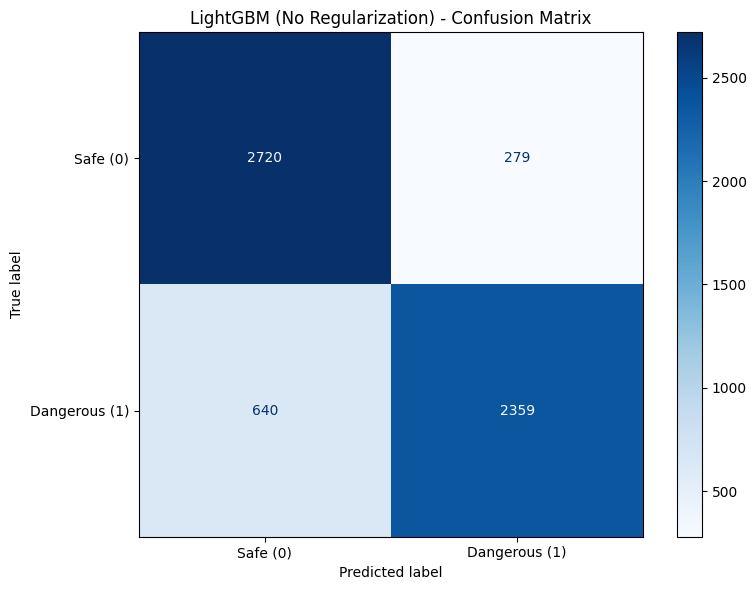

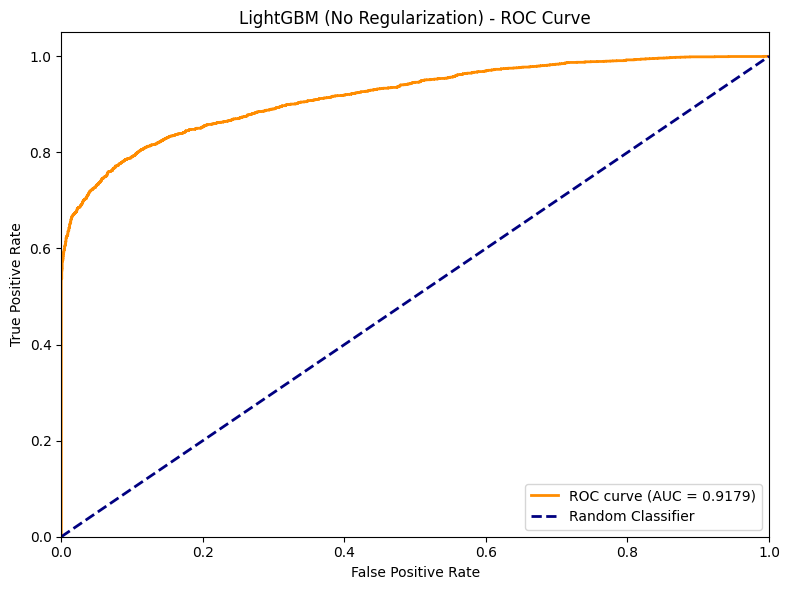

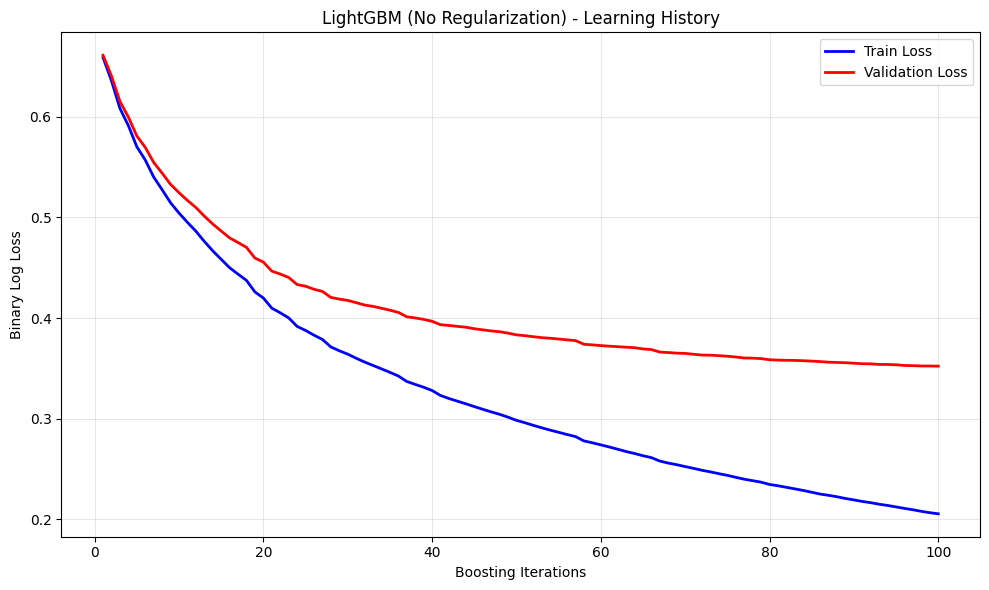

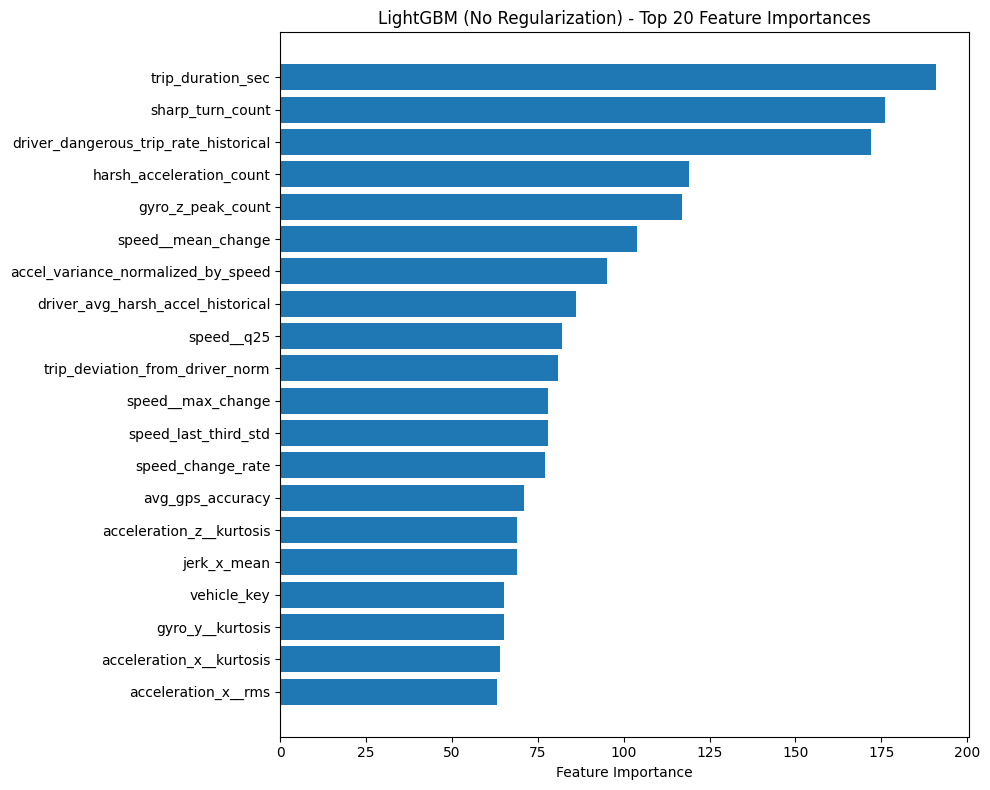

2026/01/31 17:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/31 17:33:29 WARNING mlflow.lightgbm: Saving the models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.



✅ Run logged to MLflow with ID: b259db4240ce4eedae3f896f52051bf0
🏃 View run LightGBM_NoReg_Baseline at: http://localhost:5000/#/experiments/5/runs/b259db4240ce4eedae3f896f52051bf0
🧪 View experiment at: http://localhost:5000/#/experiments/5


In [28]:
# Train the model without regularization
with mlflow.start_run(run_name="LightGBM_NoReg_Baseline"):
    # Log parameters
    mlflow.log_params(lgbm_noreg.get_params())
    mlflow.log_param("regularization", "none")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model with eval_set for learning history
    print("Training LightGBM without regularization...")
    lgbm_noreg.fit(
        X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
        eval_names=['train', 'validation']
    )
    evals_result_noreg = lgbm_noreg.evals_result_
    
    # Evaluate
    metrics_noreg, y_pred_noreg, y_proba_noreg = evaluate_model(
        lgbm_noreg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="LightGBM (No Regularization)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_noreg['train_accuracy'],
        'test_accuracy': metrics_noreg['test_accuracy'],
        'train_f1': metrics_noreg['train_f1'],
        'test_f1': metrics_noreg['test_f1'],
        'precision': metrics_noreg['precision'],
        'recall': metrics_noreg['recall'],
        'roc_auc': metrics_noreg['roc_auc'],
        'overfit_gap': metrics_noreg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_noreg, "LightGBM (No Regularization)")
    mlflow.log_figure(fig_cm, "confusion_matrix_noreg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_noreg, "LightGBM (No Regularization)")
    mlflow.log_figure(fig_roc, "roc_curve_noreg.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history(evals_result_noreg, "LightGBM (No Regularization)")
    mlflow.log_figure(fig_lh, "learning_history_noreg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(lgbm_noreg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="LightGBM (No Regularization)")
    mlflow.log_figure(fig_fi, "feature_importance_noreg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.lightgbm.log_model(lgbm_noreg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [29]:
# Cross-validation for no-reg model
print("\n" + "="*60)
print("Cross-Validation for LightGBM (No Regularization)")
print("="*60)
cv_results_noreg = perform_cross_validation(lgbm_noreg, X_train_scaled, y_train)


Cross-Validation for LightGBM (No Regularization)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.9728 (+/- 0.0012) | Test: 0.8277 (+/- 0.0054)
PRECISION    - Train: 0.9934 (+/- 0.0018) | Test: 0.8850 (+/- 0.0093)
RECALL       - Train: 0.9531 (+/- 0.0032) | Test: 0.7773 (+/- 0.0120)
ROC_AUC      - Train: 0.9986 (+/- 0.0001) | Test: 0.9133 (+/- 0.0022)
ACCURACY     - Train: 0.9734 (+/- 0.0012) | Test: 0.8381 (+/- 0.0043)


In [30]:
# Classification Report
print("\nClassification Report (No Regularization):")
print(classification_report(y_test, y_pred_noreg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (No Regularization):
               precision    recall  f1-score   support

     Safe (0)       0.81      0.91      0.86      2999
Dangerous (1)       0.89      0.79      0.84      2999

     accuracy                           0.85      5998
    macro avg       0.85      0.85      0.85      5998
 weighted avg       0.85      0.85      0.85      5998



---
## 8. Model Training WITH Regularization
### LightGBM with Regularization to Combat Overfitting

In [31]:
# Set experiment for regularized model
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_reg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_reg")

Experiment: LightGBM_balanced_smote_reg


In [32]:
# LightGBM WITH Regularization
lgbm_reg = LGBMClassifier(
    n_estimators=300,
    max_depth=6,  # Reduced depth
    learning_rate=0.05,  # Lower learning rate
    num_leaves=31,  # Reduced number of leaves (default)
    min_child_samples=20,  # Higher value for regularization
    min_child_weight=1e-2,  # Higher value
    subsample=0.8,  # Use 80% of samples per tree (bagging)
    subsample_freq=5,  # Frequency for bagging
    colsample_bytree=0.8,  # Use 80% of features
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    min_gain_to_split=0.01,  # Minimum gain for split
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("LightGBM Model (With Regularization) Configuration:")
print("\nRegularization techniques applied:")
print("- Reduced max_depth: 15 -> 6")
print("- Lower learning_rate: 0.1 -> 0.05")
print("- Reduced num_leaves: 127 -> 31")
print("- Increased min_child_samples: 5 -> 20")
print("- Subsampling: 1.0 -> 0.8")
print("- Column sampling: 1.0 -> 0.8")
print("- L1 regularization (reg_alpha): 0 -> 0.1")
print("- L2 regularization (reg_lambda): 0 -> 0.1")
print("- Added min_gain_to_split: 0.01")

LightGBM Model (With Regularization) Configuration:

Regularization techniques applied:
- Reduced max_depth: 15 -> 6
- Lower learning_rate: 0.1 -> 0.05
- Reduced num_leaves: 127 -> 31
- Increased min_child_samples: 5 -> 20
- Subsampling: 1.0 -> 0.8
- Column sampling: 1.0 -> 0.8
- L1 regularization (reg_alpha): 0 -> 0.1
- L2 regularization (reg_lambda): 0 -> 0.1
- Added min_gain_to_split: 0.01


Training LightGBM with regularization...

LightGBM (Regularized) Evaluation Results

Accuracy  - Train: 0.9161 | Test: 0.8384
F1 Score  - Train: 0.9112 | Test: 0.8269
Precision: 0.8904
Recall:    0.7719
ROC-AUC:   0.9148

Overfit Gap (Train F1 - Test F1): 0.0843
⚠️  WARNING: Model shows signs of overfitting!


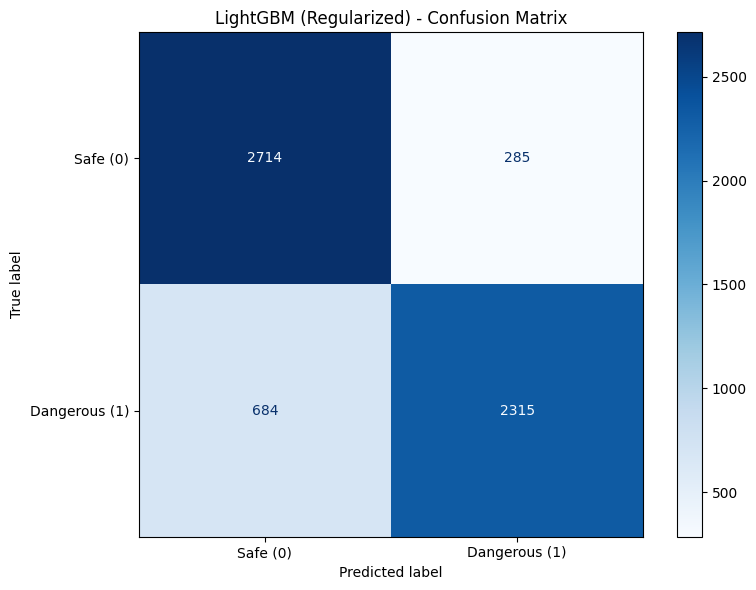

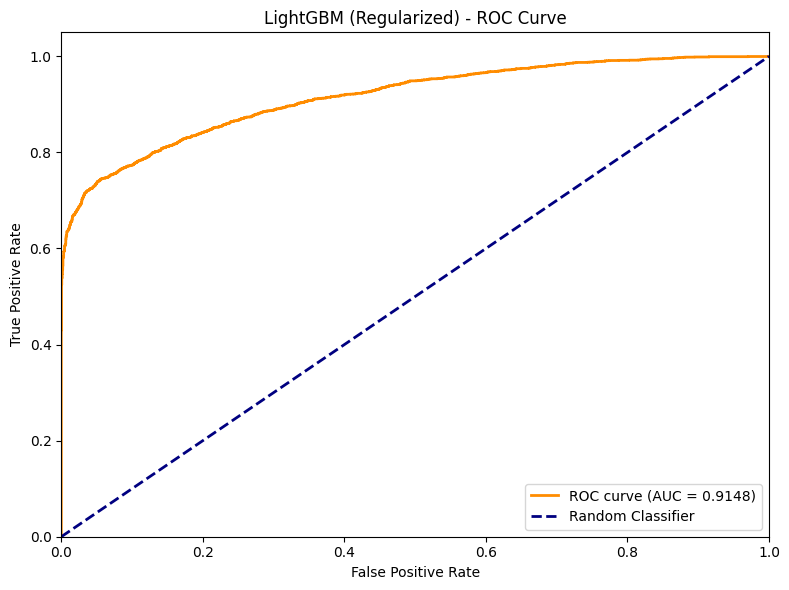

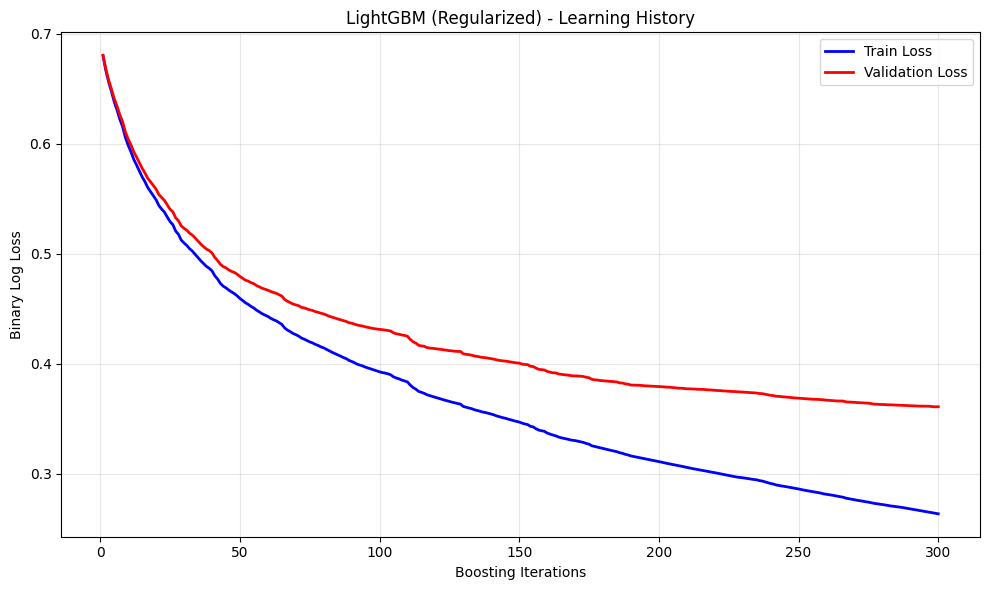

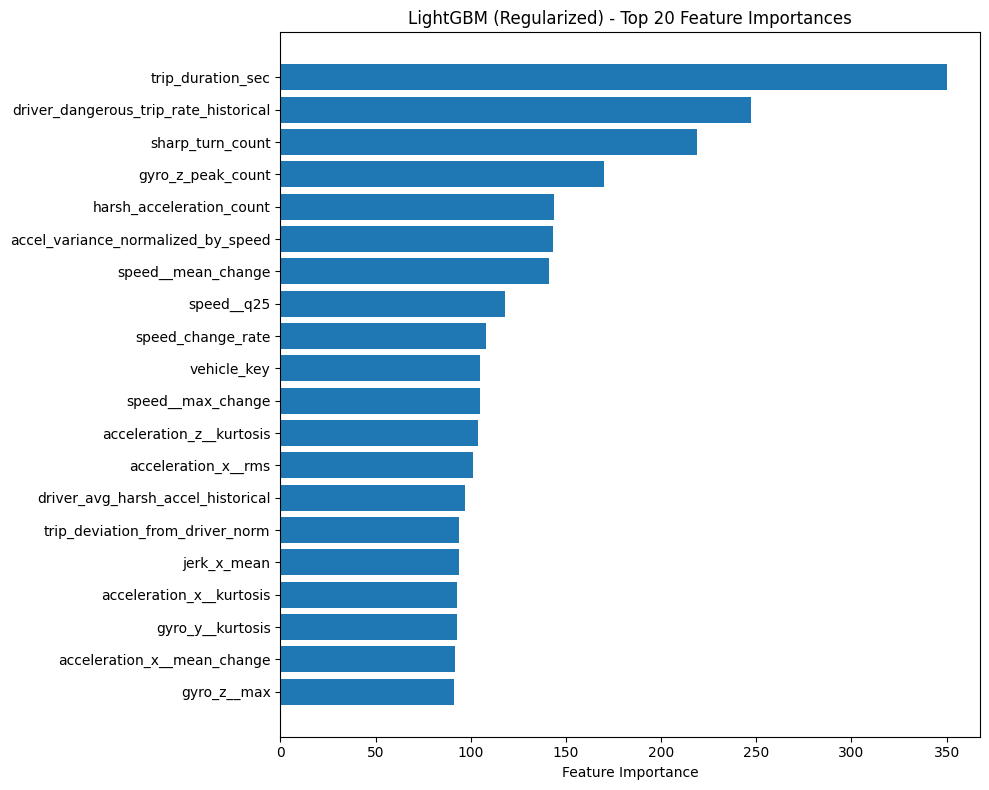

2026/01/31 17:33:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/31 17:33:40 WARNING mlflow.lightgbm: Saving the models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.



✅ Run logged to MLflow with ID: 63b506e2922244eb987f6c21b6ef07d1
🏃 View run LightGBM_Regularized at: http://localhost:5000/#/experiments/6/runs/63b506e2922244eb987f6c21b6ef07d1
🧪 View experiment at: http://localhost:5000/#/experiments/6


In [33]:
# Train the model with regularization
with mlflow.start_run(run_name="LightGBM_Regularized"):
    # Log parameters
    mlflow.log_params(lgbm_reg.get_params())
    mlflow.log_param("regularization", "L1_L2_bagging")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model with eval_set for learning history
    print("Training LightGBM with regularization...")
    lgbm_reg.fit(
        X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
        eval_names=['train', 'validation']
    )
    evals_result_reg = lgbm_reg.evals_result_
    
    # Evaluate
    metrics_reg, y_pred_reg, y_proba_reg = evaluate_model(
        lgbm_reg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="LightGBM (Regularized)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_reg['train_accuracy'],
        'test_accuracy': metrics_reg['test_accuracy'],
        'train_f1': metrics_reg['train_f1'],
        'test_f1': metrics_reg['test_f1'],
        'precision': metrics_reg['precision'],
        'recall': metrics_reg['recall'],
        'roc_auc': metrics_reg['roc_auc'],
        'overfit_gap': metrics_reg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_reg, "LightGBM (Regularized)")
    mlflow.log_figure(fig_cm, "confusion_matrix_reg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_reg, "LightGBM (Regularized)")
    mlflow.log_figure(fig_roc, "roc_curve_reg.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history(evals_result_reg, "LightGBM (Regularized)")
    mlflow.log_figure(fig_lh, "learning_history_reg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(lgbm_reg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="LightGBM (Regularized)")
    mlflow.log_figure(fig_fi, "feature_importance_reg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.lightgbm.log_model(lgbm_reg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [34]:
# Cross-validation for regularized model
print("\n" + "="*60)
print("Cross-Validation for LightGBM (Regularized)")
print("="*60)
cv_results_reg = perform_cross_validation(lgbm_reg, X_train_scaled, y_train)


Cross-Validation for LightGBM (Regularized)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.9245 (+/- 0.0040) | Test: 0.8246 (+/- 0.0058)
PRECISION    - Train: 0.9714 (+/- 0.0022) | Test: 0.8836 (+/- 0.0059)
RECALL       - Train: 0.8818 (+/- 0.0064) | Test: 0.7731 (+/- 0.0100)
ROC_AUC      - Train: 0.9856 (+/- 0.0011) | Test: 0.9111 (+/- 0.0050)
ACCURACY     - Train: 0.9279 (+/- 0.0037) | Test: 0.8356 (+/- 0.0048)


In [35]:
# Classification Report
print("\nClassification Report (Regularized):")
print(classification_report(y_test, y_pred_reg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Regularized):
               precision    recall  f1-score   support

     Safe (0)       0.80      0.90      0.85      2999
Dangerous (1)       0.89      0.77      0.83      2999

     accuracy                           0.84      5998
    macro avg       0.84      0.84      0.84      5998
 weighted avg       0.84      0.84      0.84      5998



---
## 9. Model Improvement (If F1 Score is Low)
### Enhanced LightGBM with Additional Preprocessing and Tuning

In [36]:
# Check if F1 score needs improvement (target: 0.87-0.90)
# First, determine which model performs better: regularized or non-regularized
f1_target_min = 0.87

print("="*60)
print("MODEL COMPARISON: Regularized vs Non-Regularized")
print("="*60)
print(f"No Regularization - Test F1: {metrics_noreg['test_f1']:.4f} | Overfit Gap: {metrics_noreg['overfit_gap']:.4f}")
print(f"Regularized       - Test F1: {metrics_reg['test_f1']:.4f} | Overfit Gap: {metrics_reg['overfit_gap']:.4f}")

# Select the better model based on Test F1 score
if metrics_noreg['test_f1'] > metrics_reg['test_f1']:
    best_base_model = 'noreg'
    best_base_f1 = metrics_noreg['test_f1']
    best_base_metrics = metrics_noreg
    print(f"\n🏆 Better Model: No Regularization (Test F1: {best_base_f1:.4f})")
else:
    best_base_model = 'reg'
    best_base_f1 = metrics_reg['test_f1']
    best_base_metrics = metrics_reg
    print(f"\n🏆 Better Model: Regularized (Test F1: {best_base_f1:.4f})")

print(f"\nTarget F1 Score Range: {f1_target_min} - 0.90")

if best_base_f1 < f1_target_min:
    print(f"\n⚠️  Best model F1 ({best_base_f1:.4f}) is below target. Applying improvements to {best_base_model} model...")
    NEEDS_IMPROVEMENT = True
else:
    print(f"\n✅ Best model F1 meets target. Model improvement optional.")
    NEEDS_IMPROVEMENT = False

MODEL COMPARISON: Regularized vs Non-Regularized
No Regularization - Test F1: 0.8370 | Overfit Gap: 0.1208
Regularized       - Test F1: 0.8269 | Overfit Gap: 0.0843

🏆 Better Model: No Regularization (Test F1: 0.8370)

Target F1 Score Range: 0.87 - 0.90

⚠️  Best model F1 (0.8370) is below target. Applying improvements to noreg model...


In [37]:
# Enhanced preprocessing: Remove low-variance features
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train_scaled)
X_test_var = variance_selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[variance_selector.get_support()].tolist()

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Features after variance threshold: {X_train_var.shape[1]}")
print(f"Features removed: {X_train_scaled.shape[1] - X_train_var.shape[1]}")

Original features: 141
Features after variance threshold: 141
Features removed: 0


In [38]:
# Improved LightGBM with optimized hyperparameters
lgbm_improved = LGBMClassifier(
    n_estimators=500,  # More trees with lower learning rate
    max_depth=5,  # Slightly shallower
    learning_rate=0.03,  # Even lower learning rate
    num_leaves=25,  # Fewer leaves
    min_child_samples=30,  # More conservative
    min_child_weight=0.05,
    subsample=0.75,
    subsample_freq=5,
    colsample_bytree=0.75,
    reg_alpha=0.2,  # Stronger L1
    reg_lambda=0.2,  # Stronger L2
    min_gain_to_split=0.02,
    path_smooth=0.1,  # Additional smoothing
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Improved LightGBM Configuration:")
print("- Increased n_estimators: 300 -> 500")
print("- Reduced learning_rate: 0.05 -> 0.03")
print("- Further reduced num_leaves: 31 -> 25")
print("- Stronger regularization")
print("- Added path_smooth for stability")

Improved LightGBM Configuration:
- Increased n_estimators: 300 -> 500
- Reduced learning_rate: 0.05 -> 0.03
- Further reduced num_leaves: 31 -> 25
- Stronger regularization
- Added path_smooth for stability


Training improved LightGBM...

LightGBM (Improved) Evaluation Results

Accuracy  - Train: 0.8888 | Test: 0.8354
F1 Score  - Train: 0.8813 | Test: 0.8236
Precision: 0.8875
Recall:    0.7683
ROC-AUC:   0.9116

Overfit Gap (Train F1 - Test F1): 0.0577
⚠️  WARNING: Model shows signs of overfitting!


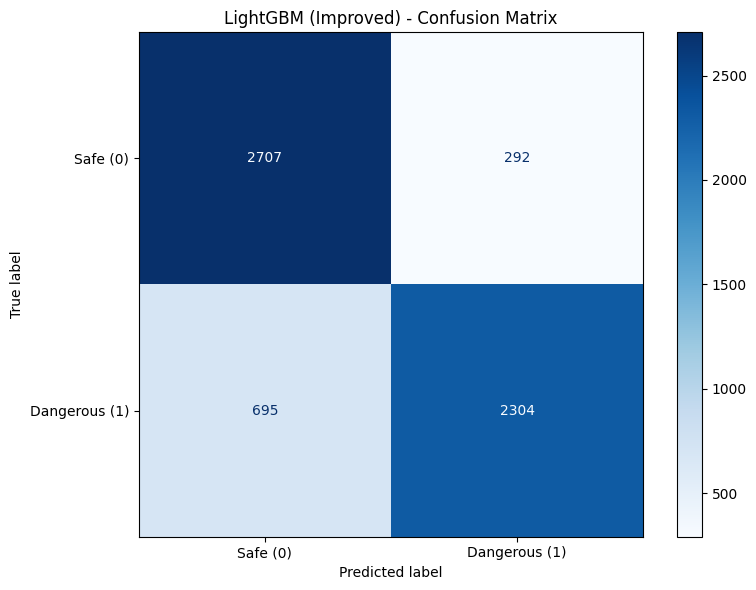

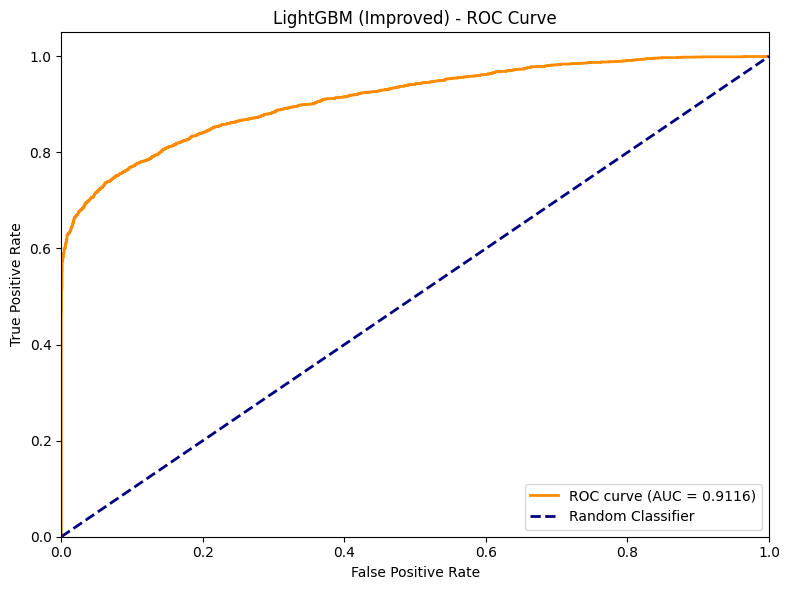

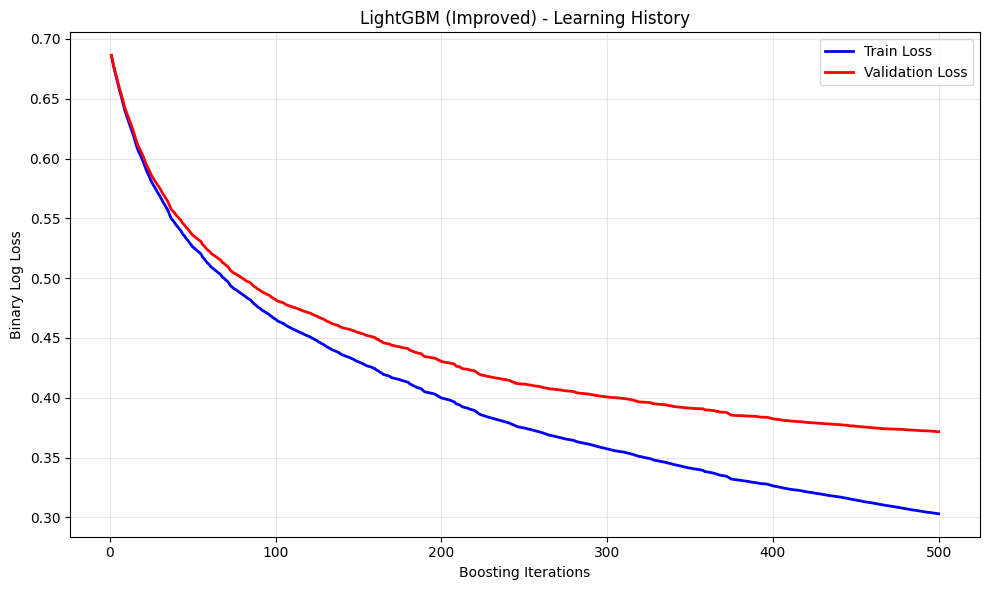

2026/01/31 17:33:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/31 17:33:50 WARNING mlflow.lightgbm: Saving the models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.



✅ Run logged to MLflow with ID: ae3deeaeee664d748fa8ccd5e8faa5fa
🏃 View run LightGBM_Improved at: http://localhost:5000/#/experiments/6/runs/ae3deeaeee664d748fa8ccd5e8faa5fa
🧪 View experiment at: http://localhost:5000/#/experiments/6


In [39]:
# Train improved model
with mlflow.start_run(run_name="LightGBM_Improved"):
    # Log parameters
    mlflow.log_params(lgbm_improved.get_params())
    mlflow.log_param("regularization", "enhanced")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("preprocessing", "variance_threshold")
    mlflow.log_param("n_features", X_train_var.shape[1])
    mlflow.log_param("n_train_samples", X_train_var.shape[0])
    
    # Train model with eval_set for learning history
    print("Training improved LightGBM...")
    lgbm_improved.fit(
        X_train_var, y_train,
        eval_set=[(X_train_var, y_train), (X_test_var, y_test)],
        eval_names=['train', 'validation']
    )
    evals_result_improved = lgbm_improved.evals_result_
    
    # Evaluate
    metrics_improved, y_pred_improved, y_proba_improved = evaluate_model(
        lgbm_improved, X_train_var, X_test_var, y_train, y_test, 
        model_name="LightGBM (Improved)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_improved['train_accuracy'],
        'test_accuracy': metrics_improved['test_accuracy'],
        'train_f1': metrics_improved['train_f1'],
        'test_f1': metrics_improved['test_f1'],
        'precision': metrics_improved['precision'],
        'recall': metrics_improved['recall'],
        'roc_auc': metrics_improved['roc_auc'],
        'overfit_gap': metrics_improved['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_improved, "LightGBM (Improved)")
    mlflow.log_figure(fig_cm, "confusion_matrix_improved.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_improved, "LightGBM (Improved)")
    mlflow.log_figure(fig_roc, "roc_curve_improved.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history(evals_result_improved, "LightGBM (Improved)")
    mlflow.log_figure(fig_lh, "learning_history_improved.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_var, y_train)
    mlflow.lightgbm.log_model(lgbm_improved, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [40]:
# Classification Report for improved model
print("\nClassification Report (Improved):")
print(classification_report(y_test, y_pred_improved, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Improved):
               precision    recall  f1-score   support

     Safe (0)       0.80      0.90      0.85      2999
Dangerous (1)       0.89      0.77      0.82      2999

     accuracy                           0.84      5998
    macro avg       0.84      0.84      0.83      5998
 weighted avg       0.84      0.84      0.83      5998



---
## 10. Model Comparison Summary

In [41]:
# Summary comparison of all models
comparison_df = pd.DataFrame({
    'Model': ['LightGBM (No Reg)', 'LightGBM (Regularized)', 'LightGBM (Improved)'],
    'Train F1': [metrics_noreg['train_f1'], metrics_reg['train_f1'], metrics_improved['train_f1']],
    'Test F1': [metrics_noreg['test_f1'], metrics_reg['test_f1'], metrics_improved['test_f1']],
    'Precision': [metrics_noreg['precision'], metrics_reg['precision'], metrics_improved['precision']],
    'Recall': [metrics_noreg['recall'], metrics_reg['recall'], metrics_improved['recall']],
    'ROC-AUC': [metrics_noreg['roc_auc'], metrics_reg['roc_auc'], metrics_improved['roc_auc']],
    'Overfit Gap': [metrics_noreg['overfit_gap'], metrics_reg['overfit_gap'], metrics_improved['overfit_gap']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Highlight best model
best_idx = comparison_df['Test F1'].idxmax()
print(f"\n🏆 Best Model by Test F1: {comparison_df.loc[best_idx, 'Model']} (F1: {comparison_df.loc[best_idx, 'Test F1']:.4f})")


MODEL COMPARISON SUMMARY
                 Model  Train F1  Test F1  Precision   Recall  ROC-AUC  Overfit Gap
     LightGBM (No Reg)  0.957790 0.836970   0.894238 0.786596 0.917853     0.120820
LightGBM (Regularized)  0.911192 0.826933   0.890385 0.771924 0.914783     0.084259
   LightGBM (Improved)  0.881314 0.823592   0.887519 0.768256 0.911595     0.057721

🏆 Best Model by Test F1: LightGBM (No Reg) (F1: 0.8370)


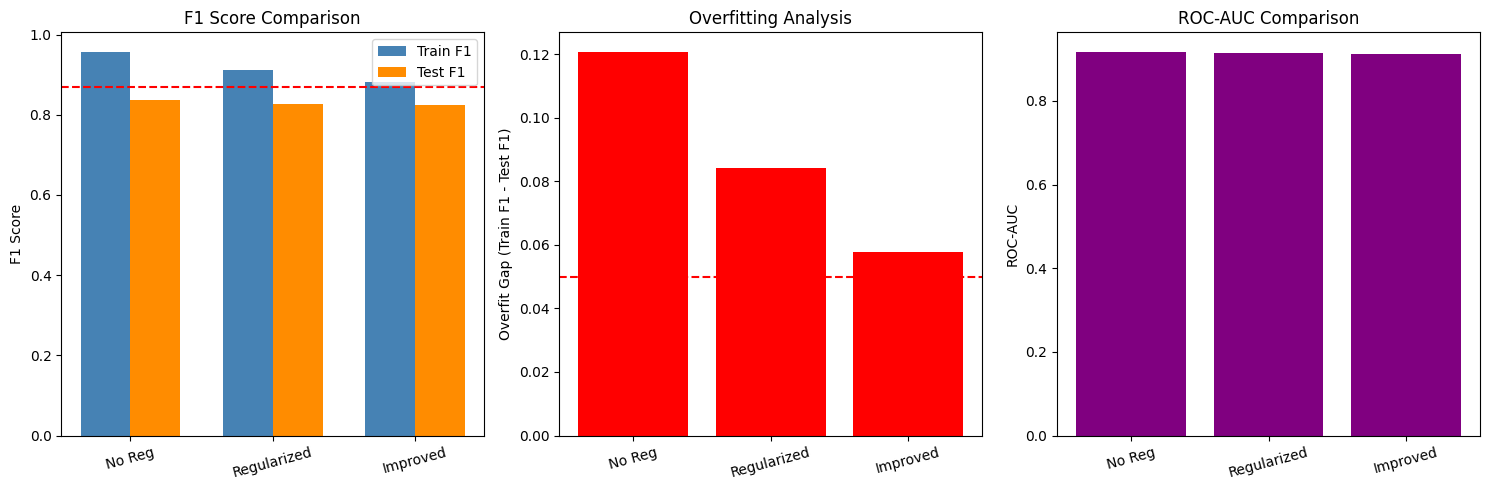

In [42]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score comparison
x = range(len(comparison_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], comparison_df['Train F1'], width, label='Train F1', color='steelblue')
axes[0].bar([i + width/2 for i in x], comparison_df['Test F1'], width, label='Test F1', color='darkorange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Comparison')
axes[0].legend()
axes[0].axhline(y=0.87, color='red', linestyle='--', label='Target Min')

# Overfit gap
colors = ['red' if gap > 0.05 else 'green' for gap in comparison_df['Overfit Gap']]
axes[1].bar(x, comparison_df['Overfit Gap'], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[1].set_ylabel('Overfit Gap (Train F1 - Test F1)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Overfit Threshold')

# ROC-AUC comparison
axes[2].bar(x, comparison_df['ROC-AUC'], color='purple')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('ROC-AUC Comparison')

plt.tight_layout()
plt.show()

---
## 11. Hyperparameter Tuning

Perform hyperparameter tuning on the best model from ablation study using RandomizedSearchCV for efficiency.

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

# Determine best base model for tuning
base_models = {
    'noreg': (lgbm_noreg, metrics_noreg, 'No Regularization'),
    'reg': (lgbm_reg, metrics_reg, 'Regularized'),
    'improved': (lgbm_improved, metrics_improved, 'Improved')
}

best_base_name = max(base_models.keys(), key=lambda k: base_models[k][1]['test_f1'])
best_base_model, best_base_metrics, best_base_label = base_models[best_base_name]

print(f"Best base model for tuning: LightGBM ({best_base_label})")
print(f"Current Test F1: {best_base_metrics['test_f1']:.4f}")
print(f"Current Overfit Gap: {best_base_metrics['overfit_gap']:.4f}")

Best base model for tuning: LightGBM (No Regularization)
Current Test F1: 0.8370
Current Overfit Gap: 0.1208


In [44]:
# Define hyperparameter search space for LightGBM
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.20
    'num_leaves': randint(15, 63),
    'min_child_samples': randint(10, 50),
    'min_child_weight': uniform(0.001, 0.1),
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5)
}

# Create base model for tuning
lgbm_tune = LGBMClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Hyperparameter Search Space:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Hyperparameter Search Space:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000252D2D91FD0>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000252D2DB4410>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000252D2D92120>
  num_leaves: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000252D2DB47D0>
  min_child_samples: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000252D10B2650>
  min_child_weight: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000252D2DB4910>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000252D2DB4B90>
  colsample_bytree: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000252D10B29E0>
  reg_alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000252D10B28B0>
  reg_lambda: <scipy.stats._distn_infrastructure.rv_contin

In [45]:
# Set experiment for hyperparameter tuning
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_tuned")

# Perform randomized search
print("\nStarting Hyperparameter Tuning (this may take several minutes)...")
print("="*60)

start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=lgbm_tune,
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter combinations to try
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)

tuning_time = time.time() - start_time
print(f"\nTuning completed in {tuning_time/60:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

2026/01/31 17:33:53 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM_balanced_smote_tuned' does not exist. Creating a new experiment.



Starting Hyperparameter Tuning (this may take several minutes)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Tuning completed in 1.95 minutes

Best parameters found:
  colsample_bytree: 0.9378135394712606
  learning_rate: 0.1519908209261024
  max_depth: 7
  min_child_samples: 33
  min_child_weight: 0.03667533266935893
  n_estimators: 351
  num_leaves: 59
  reg_alpha: 0.07046211248738132
  reg_lambda: 0.40109849037701983
  subsample: 0.6298202574719083

Best CV F1 Score: 0.8408



LightGBM (Tuned) Evaluation Results

Accuracy  - Train: 1.0000 | Test: 0.8596
F1 Score  - Train: 1.0000 | Test: 0.8527
Precision: 0.8969
Recall:    0.8126
ROC-AUC:   0.9316

Overfit Gap (Train F1 - Test F1): 0.1473
⚠️  WARNING: Model shows signs of overfitting!


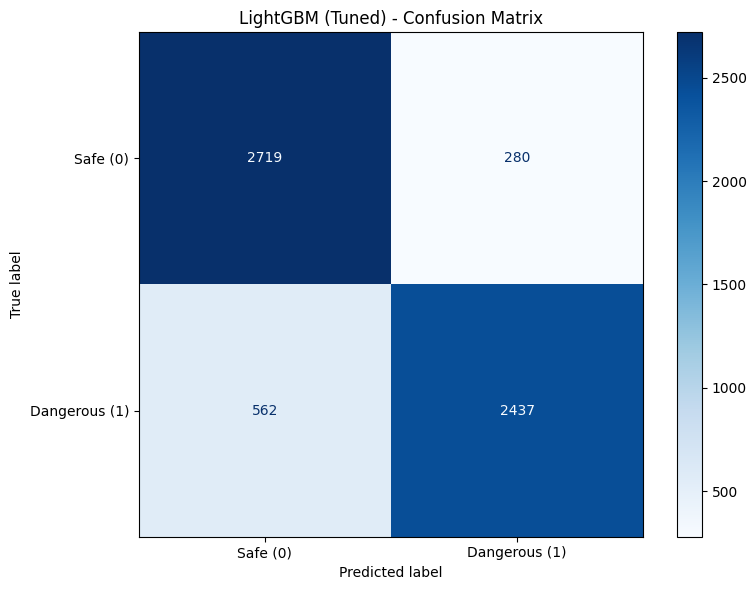

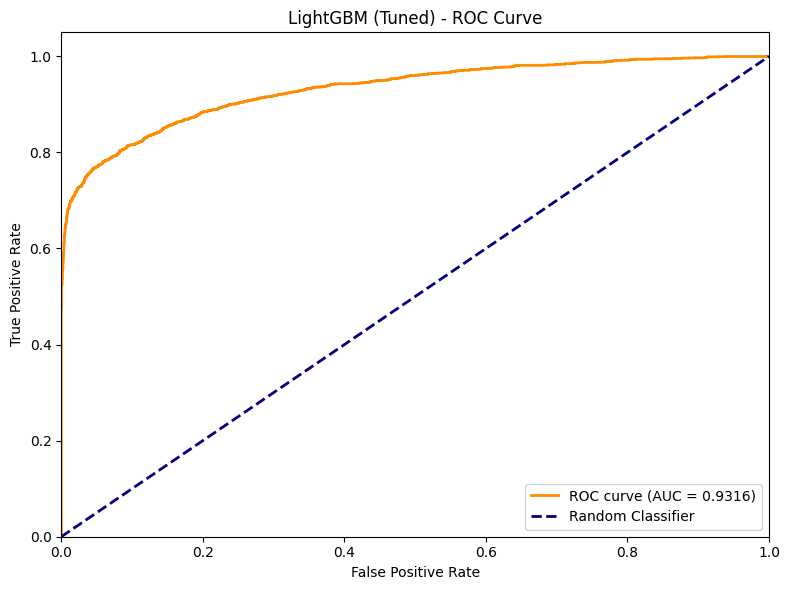

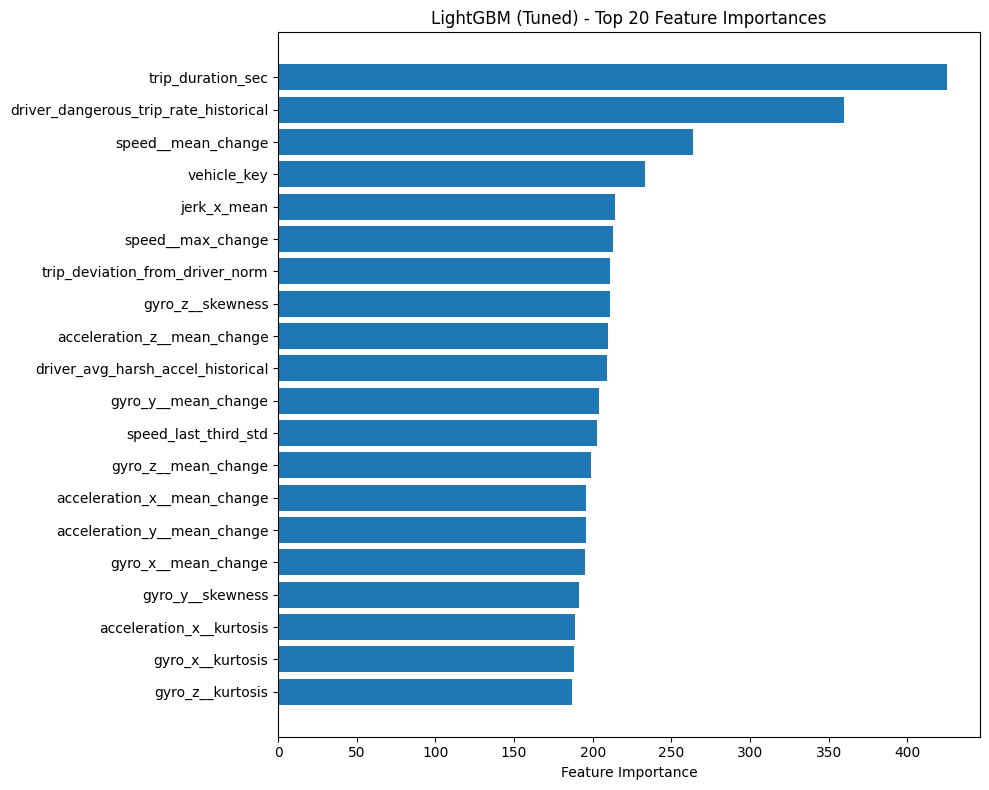

2026/01/31 17:35:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/31 17:35:56 WARNING mlflow.lightgbm: Saving the models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.



✅ Tuned model logged to MLflow with ID: 95de35b47bba4460a5de01af880da1c7
🏃 View run LightGBM_Tuned at: http://localhost:5000/#/experiments/18/runs/95de35b47bba4460a5de01af880da1c7
🧪 View experiment at: http://localhost:5000/#/experiments/18


In [46]:
# Evaluate tuned model
lgbm_tuned = random_search.best_estimator_

with mlflow.start_run(run_name="LightGBM_Tuned"):
    # Log best parameters
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("tuning_time_minutes", round(tuning_time/60, 2))
    
    # Evaluate tuned model
    metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
        lgbm_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="LightGBM (Tuned)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_tuned['train_accuracy'],
        'test_accuracy': metrics_tuned['test_accuracy'],
        'train_f1': metrics_tuned['train_f1'],
        'test_f1': metrics_tuned['test_f1'],
        'precision': metrics_tuned['precision'],
        'recall': metrics_tuned['recall'],
        'roc_auc': metrics_tuned['roc_auc'],
        'overfit_gap': metrics_tuned['overfit_gap'],
        'cv_best_f1': random_search.best_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_tuned, "LightGBM (Tuned)")
    mlflow.log_figure(fig_cm, "confusion_matrix_tuned.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_tuned, "LightGBM (Tuned)")
    mlflow.log_figure(fig_roc, "roc_curve_tuned.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(lgbm_tuned, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="LightGBM (Tuned)")
    mlflow.log_figure(fig_fi, "feature_importance_tuned.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.lightgbm.log_model(lgbm_tuned, "model", signature=signature)
    
    print(f"\n✅ Tuned model logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [47]:
# Compare tuned model with best base model
print("\n" + "="*70)
print("TUNING COMPARISON: Best Base Model vs Tuned Model")
print("="*70)

comparison_tuning = pd.DataFrame({
    'Model': [f'LightGBM ({best_base_label})', 'LightGBM (Tuned)'],
    'Train F1': [best_base_metrics['train_f1'], metrics_tuned['train_f1']],
    'Test F1': [best_base_metrics['test_f1'], metrics_tuned['test_f1']],
    'ROC-AUC': [best_base_metrics['roc_auc'], metrics_tuned['roc_auc']],
    'Overfit Gap': [best_base_metrics['overfit_gap'], metrics_tuned['overfit_gap']]
})

print(comparison_tuning.to_string(index=False))

# Calculate improvement
f1_improvement = metrics_tuned['test_f1'] - best_base_metrics['test_f1']
overfit_improvement = best_base_metrics['overfit_gap'] - metrics_tuned['overfit_gap']

print(f"\n📊 Improvement Summary:")
print(f"   F1 Score Change: {f1_improvement:+.4f} ({'✅ Improved' if f1_improvement > 0 else '❌ No improvement'})")
print(f"   Overfit Gap Change: {overfit_improvement:+.4f} ({'✅ Less overfitting' if overfit_improvement > 0 else '⚠️ More overfitting'})")

# Determine final best model
TUNING_IMPROVED = metrics_tuned['test_f1'] > best_base_metrics['test_f1']
if TUNING_IMPROVED:
    print(f"\n🏆 Tuned model is better! Will save tuned model.")
else:
    print(f"\n📌 Base model ({best_base_label}) is better or equal. Will save base model.")


TUNING COMPARISON: Best Base Model vs Tuned Model
                       Model  Train F1  Test F1  ROC-AUC  Overfit Gap
LightGBM (No Regularization)   0.95779 0.836970 0.917853     0.120820
            LightGBM (Tuned)   1.00000 0.852694 0.931625     0.147306

📊 Improvement Summary:
   F1 Score Change: +0.0157 (✅ Improved)
   Overfit Gap Change: -0.0265 (⚠️ More overfitting)

🏆 Tuned model is better! Will save tuned model.


---
## 12. Save Best Model

In [48]:
import joblib
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Determine best model (including tuned)
models = {
    'noreg': (lgbm_noreg, metrics_noreg),
    'reg': (lgbm_reg, metrics_reg),
    'improved': (lgbm_improved, metrics_improved),
    'tuned': (lgbm_tuned, metrics_tuned)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1]['test_f1'])
best_model, best_metrics = models[best_model_name]

# Save the best model
model_path = os.path.join(models_dir, 'lightgbm_best_model.joblib')
joblib.dump(best_model, model_path)

# Save the scaler
scaler_path = os.path.join(models_dir, 'lightgbm_scaler.joblib')
joblib.dump(scaler, scaler_path)

print(f"Best model saved: {model_path}")
print(f"Scaler saved: {scaler_path}")
print(f"\nBest Model: LightGBM ({best_model_name})")
print(f"Test F1 Score: {best_metrics['test_f1']:.4f}")
print(f"Overfit Gap: {best_metrics['overfit_gap']:.4f}")

Best model saved: ../models\lightgbm_best_model.joblib
Scaler saved: ../models\lightgbm_scaler.joblib

Best Model: LightGBM (tuned)
Test F1 Score: 0.8527
Overfit Gap: 0.1473


---
## Summary

This notebook trained LightGBM models for dangerous driving detection with:

1. **No Regularization (Baseline)**: High complexity model to establish baseline and identify overfitting
2. **With Regularization**: Applied L1/L2 regularization, bagging, and reduced complexity
3. **Improved Model**: Enhanced preprocessing and optimized hyperparameters for better F1 score

### Key Findings:
- Class imbalance handled using `class_weight='balanced'`
- Regularization reduced overfitting gap
- LightGBM is fast and handles imbalance well natively
- All experiments tracked in MLflow for comparison

### Next Steps:
- Compare with other models (XGBoost, Random Forest, etc.)
- Run hyperparameter tuning if needed
- Deploy best model for production